In [6]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from torch.utils.data import Dataset
import datagen_temporal
from datagen_temporal import TemporalData, GTMatrices
from sensing import SensingMasks


--------------------------
Dataset of 20 labelled rank-25 matrices of size 100x25
Mean nuclear norm: 168.3045, Spectral gap: 0.0000
Mean variance of entries: 1.0000
Total entries: 2500
--------------------------
--------------------------
Target density: 0.05.
Target known entries: 125.0, Actual union known entries: 81.0
128 agents, Avg overlap (Jaccard): 0.007, Var overlap: 0.007327
Avg entries per agent: 1.0
Fraction clipped at G: 0.000
--------------------------


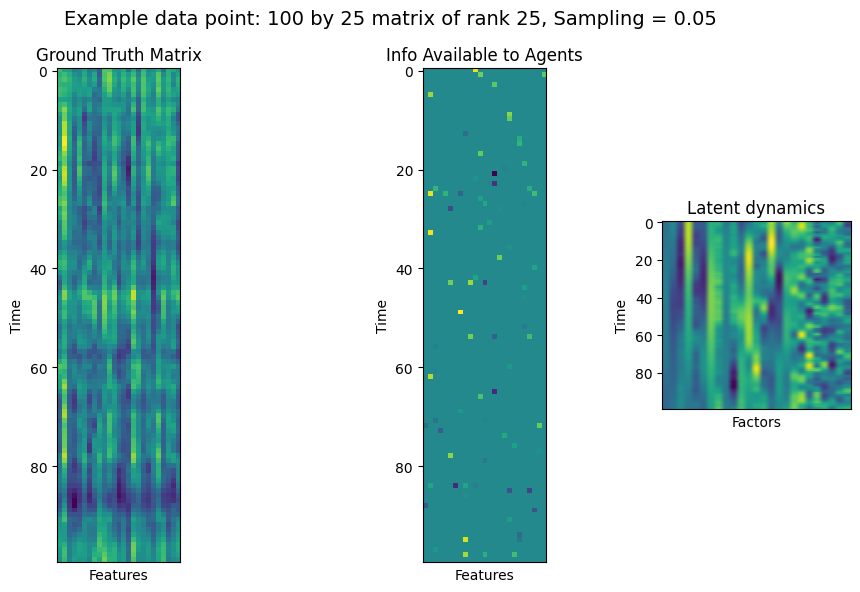

In [7]:
NUM_MATRICES = 20
NUM_AGENTS = 128
T = 100
M = 25
R = 25

groundtruth = GTMatrices(NUM_MATRICES, T, M, R)
groundtruth[:NUM_MATRICES]

trainingdata = TemporalData(groundtruth)
sensingmasks = SensingMasks(trainingdata, R, NUM_AGENTS, 0.05)

example = trainingdata[0]['matrix']
test = sensingmasks(example, global_mask=True)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(9.5, 6), gridspec_kw={
        'width_ratios': [3, 3, 1.5]
    })
axs[0].imshow(example.reshape(T, M))
axs[0].set_title("Ground Truth Matrix")
axs[0].set_xticks([])
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Time")
axs[1].imshow(test.reshape(T, M))
axs[1].set_title("Info Available to Agents")
axs[1].set_xlabel("Features")
axs[1].set_xticks([])
axs[1].set_ylabel("Time")
axs[2].imshow(groundtruth.U[0], aspect = 0.25)
axs[2].set_title("Latent dynamics")
axs[2].set_xlabel("Factors")
axs[2].set_xticks([])
axs[2].set_ylabel("Time")
fig.suptitle(
    f"Example data point: {T} by {M} matrix of rank {R}, Sampling = {sensingmasks.density}", fontsize=14)
fig.tight_layout()
plt.show()

--------------------------
Dataset of 1 labelled rank-25 matrices of size 50x25
Mean nuclear norm: 95.7096, Spectral gap: 0.0000
Mean variance of entries: 0.4469
Total entries: 1250
--------------------------


/tmp/ipykernel_976221/2606780814.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


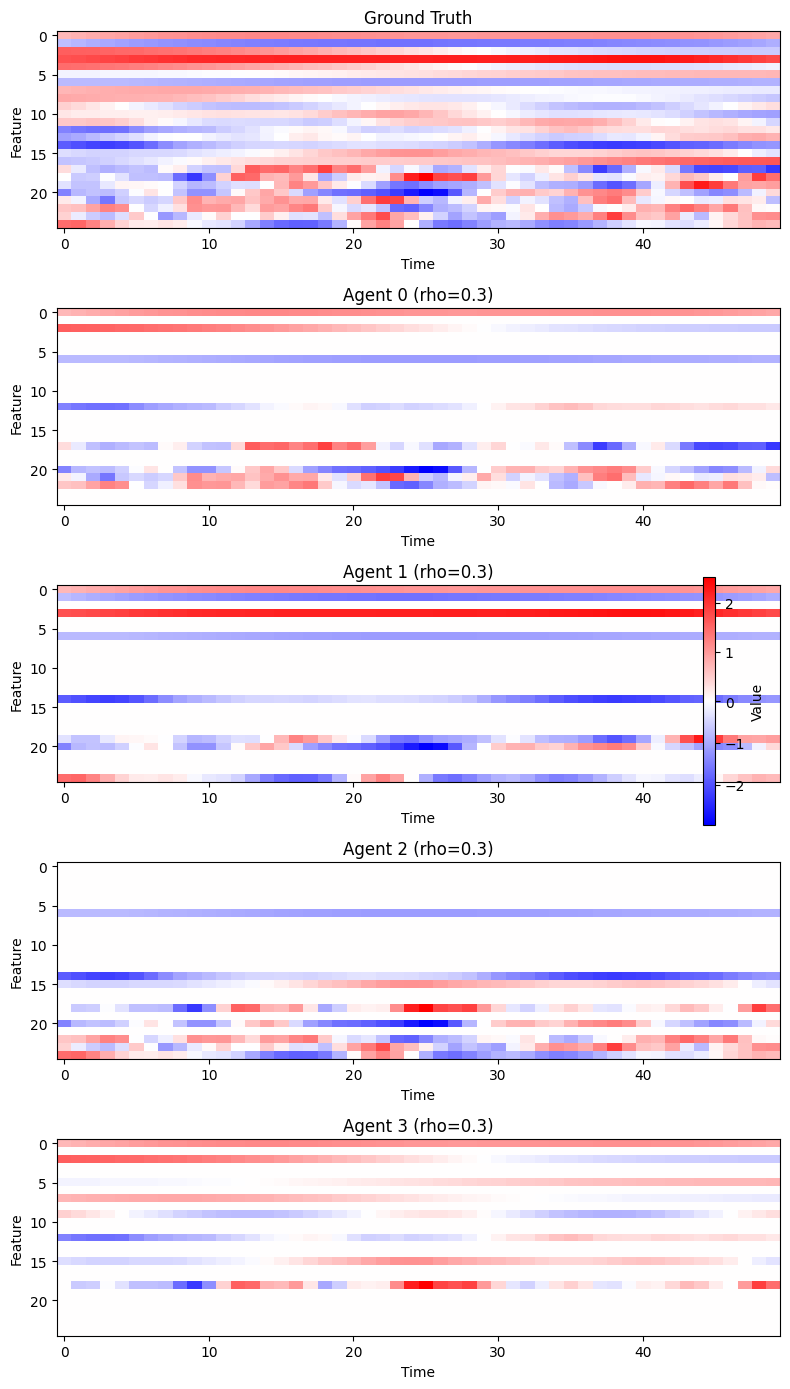

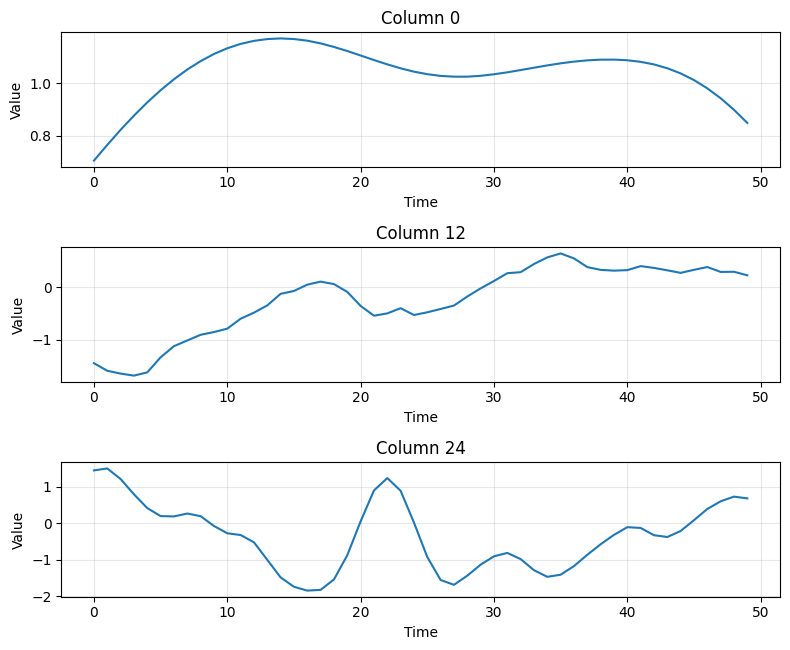

In [1]:
from datagen_temporal import GTMatrices, TemporalData
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import torch
from sensing import SensingMasksTemporal

# Parameters
NUM_MATRICES = 1
T = 50
M = 25
A = 4
R = 10
RHO = 0.3  # fraction of columns each agent observes

with torch.no_grad():
    gt = GTMatrices(N=NUM_MATRICES, t=T, m=M, r=R, realizations=1,U_only=True)
    td = TemporalData(gt)
    smt = SensingMasksTemporal(td, num_agents=A, rho=RHO, seed=42)

    sample = td[0]['matrix']          # [1, T*M]
    sample_tm = sample.view(T, M)     # [T, M]
    masked = smt(sample)              # [A, T, M]

    # Diverging normalization centered at zero (white at 0)
    vmin = float(sample_tm.min().item())
    vmax = float(sample_tm.max().item())
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    cmap = 'bwr'  # blue-white-red (zero is white)

    # Vertical stack (one column): Ground truth + one per agent, time on x-axis
    fig, axs = plt.subplots(A + 1, 1, figsize=(8, 2.8*(A+1)))
    if A + 1 == 1:
        axs = [axs]
    im = axs[0].imshow(sample_tm.T, cmap=cmap, norm=norm, aspect='auto')  # transpose so x-axis is time
    axs[0].set_title('Ground Truth')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Feature')
    for a in range(A):
        axs[a+1].imshow(masked[a].T, cmap=cmap, norm=norm, aspect='auto', interpolation='none')
        axs[a+1].set_title(f'Agent {a} (rho={RHO})')
        axs[a+1].set_xlabel('Time')
        axs[a+1].set_ylabel('Feature')
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label('Value', rotation=90)
    plt.tight_layout(); plt.show()

    # Line plots in one column (vertical), time on x-axis
    cols = [0, M//2, M-1] if M >= 3 else list(range(M))
    fig2, axs2 = plt.subplots(len(cols), 1, figsize=(8, 2.2*len(cols)))
    if len(cols) == 1:
        axs2 = [axs2]
    for i, c in enumerate(cols):
        axs2[i].plot(sample_tm[:, c])
        axs2[i].set_title(f'Column {c}')
        axs2[i].set_xlabel('Time')
        axs2[i].set_ylabel('Value')
        axs2[i].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

--------------------------
Dataset of 1 labelled rank-30 matrices of size 60x30
Mean nuclear norm: 129.4850, Spectral gap: 0.0000
Mean variance of entries: 0.5137
Total entries: 1800
--------------------------


/tmp/ipykernel_979140/55305137.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


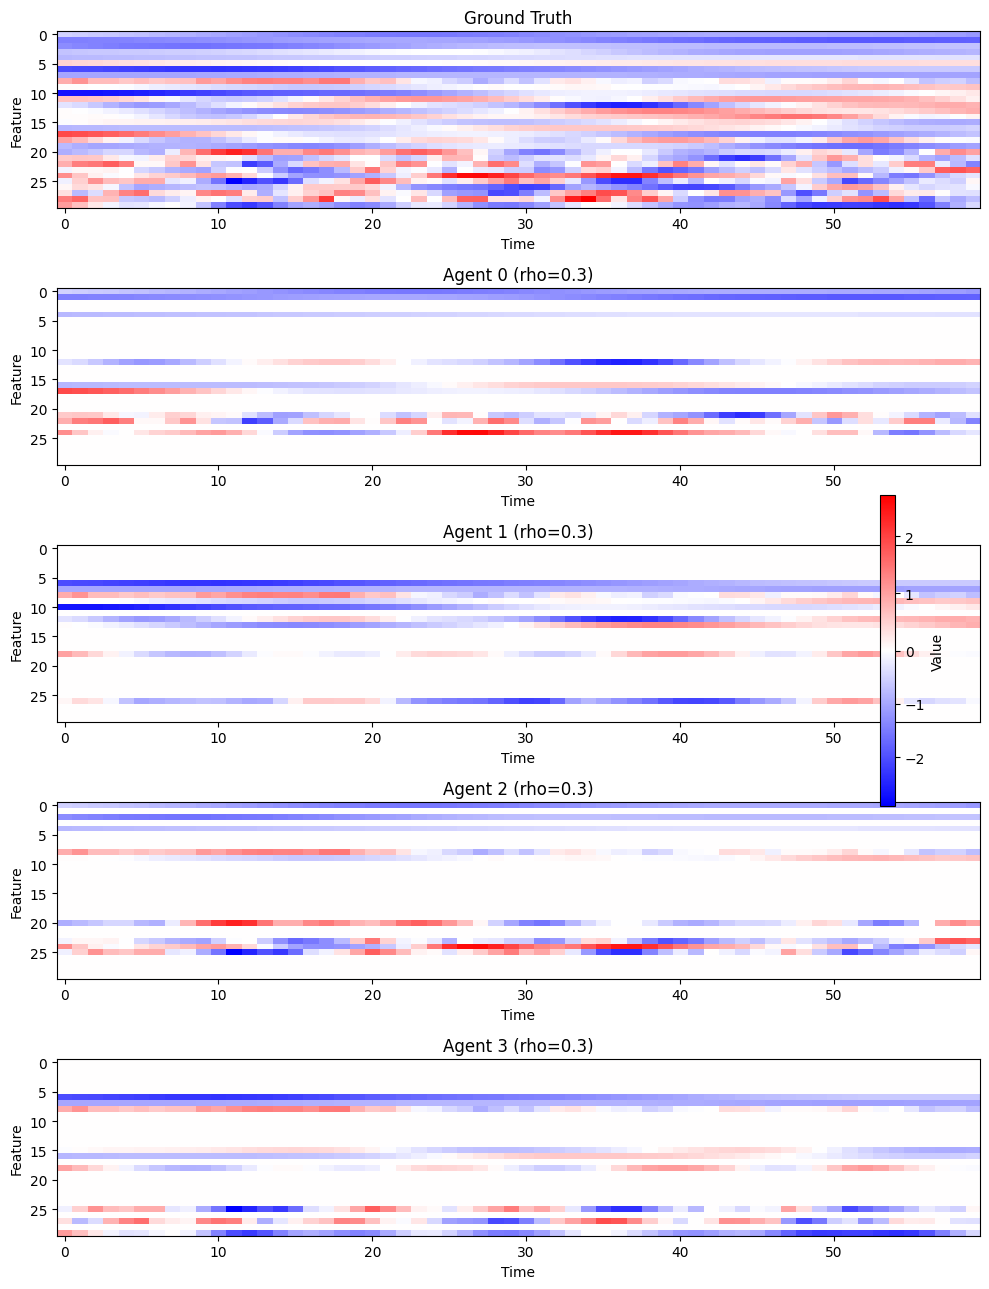

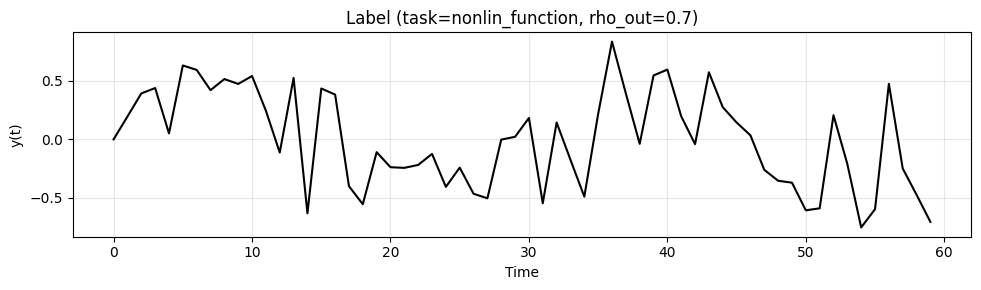

In [ ]:
# Test: Temporal data with agent-specific masks and nonlin_function labels
from datagen_temporal import GTMatrices, TemporalData
from sensing import SensingMasksTemporal
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import torch

# Parameters
NUM_MATRICES = 1
T = 60
M = 30
R = 10
A = 4           # number of agents
RHO = 0.3       # fraction of columns each agent observes
RHO_OUT = 0.2   # fraction of columns per row used for label in TemporalData

with torch.no_grad():
    # Ground truth with U_only=True
    gt = GTMatrices(N=NUM_MATRICES, t=T, m=M, r=R, realizations=1, U_only=True)
    # Temporal dataset with non-linear function labels (sequence over time)
    td = TemporalData(gt, task='nonlin_function', rho_out=RHO_OUT)
    # Agent-specific column masks
    smt = SensingMasksTemporal(td, num_agents=A, rho=RHO, seed=123)

    # Sample matrix and label
    sample_vec = td[0]['matrix']   # [1, T*M]
    sample_tm = sample_vec.view(T, M)  # [T, M]
    label_ts = td[0]['label'].view(T)  # [T]

    # Apply agent masks -> [A, T, M]
    masked = smt(sample_vec)

    # Diverging normalization centered at zero (white at 0)
    vmin = float(sample_tm.min().item())
    vmax = float(sample_tm.max().item())
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    cmap = 'bwr'  # blue-white-red (zero is white)

    # Heatmaps stacked vertically: Ground truth + one per agent (time on x-axis)
    fig, axs = plt.subplots(A + 1, 1, figsize=(10, 2.6*(A+1)))
    if A + 1 == 1:
        axs = [axs]
    im = axs[0].imshow(sample_tm.T, cmap=cmap, norm=norm, aspect='auto')  # transpose so x-axis is time
    axs[0].set_title('Ground Truth')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Feature')
    for a in range(A):
        axs[a+1].imshow(masked[a].T, cmap=cmap, norm=norm, aspect='auto', interpolation='none')
        axs[a+1].set_title(f'Agent {a} (rho={RHO})')
        axs[a+1].set_xlabel('Time')
        axs[a+1].set_ylabel('Feature')
    cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label('Value', rotation=90)
    plt.tight_layout(); plt.show()

    # Separate plot for the label time series (time on x-axis)
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 3))
    ax2.plot(torch.arange(T), label_ts, color='black', linewidth=1.5)
    ax2.set_title(f'Label (task=nonlin_function, rho_out={RHO_OUT})')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('y(t)')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

In [3]:
label_ts

tensor([ 0.0000, -1.0000, -1.0000, -1.0000, -0.9848,  0.8684, -0.9999, -1.0000,
         1.0000,  0.8861,  0.9901,  0.9999,  0.9996, -1.0000, -0.3079,  0.9248,
         0.9961,  0.5838,  1.0000,  0.9899,  0.9842,  1.0000,  0.9565, -0.6874,
        -0.9996, -0.9690, -1.0000,  1.0000, -0.9727,  1.0000,  0.7621,  0.4780,
         0.0235,  0.9622,  1.0000,  1.0000,  0.9888,  0.7670, -1.0000,  0.8132,
        -0.9000,  0.9651,  0.9998, -0.9978,  0.9995,  0.9173, -0.9908,  0.2619,
        -0.9820, -0.9997,  1.0000, -0.9942, -1.0000, -0.9801, -0.5400,  0.9755,
         0.8997,  0.9992, -0.9844,  0.3183])